In [243]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from collections import defaultdict
import missingno as msno

In [244]:
df = pd.read_csv("Data/county_data_clean.csv").drop(columns="Unnamed: 0")
df = df[df.state_abbreviation!='US']

In [245]:
features_df = df.drop(['uninsured_adults', 'uninsured_children', 'county_fips_code',
                   '5_digit_fips_code'], axis = 1)
# Replacing missing value of uninsured with mean of uninsured
features_df['uninsured'] = features_df.uninsured.replace([float("nan")], features_df.uninsured.mean())

for column in features_df.columns:
    na_sum= (features_df[column].isna().sum())
    column_size = (features_df[column].size)
    #print(na_sum/column_size)
    if (features_df[column].isna().sum()/features_df[column].size) > 0.25:
        features_df = features_df.drop(columns=column)

In [246]:
state_groupby = features_df.groupby('state_abbreviation').count()
null_count_dict = defaultdict(int)

for column in state_groupby.columns:
    null_count_dict[column] = 0
    for state in state_groupby.index:
        value = state_groupby.loc[state][column]
        size = state_groupby.loc[state]['state_fips_code']
        if (value/size) <= 0.25:
            print("{0} is not useful for {1}: {2}".format(column, state, str(value/size)))
            null_count_dict[column] += 1
            
exclude_features = []
for feature, null_count in null_count_dict.items():
    if null_count > 13:
        exclude_features.append(feature.strip(""))

null_count_dict

air_pollution__particulate_matter is not useful for AK: 0.0
air_pollution__particulate_matter is not useful for HI: 0.0
drinking_water_violations is not useful for HI: 0.0
hiv_prevalence is not useful for ND: 0.24074074074074073
hiv_prevalence is not useful for NE: 0.13829787234042554
hiv_prevalence is not useful for SD: 0.014925373134328358
children_eligible_for_free_or_reduced_price_lunch is not useful for DC: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for DE: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for MA: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for TN: 0.0


defaultdict(int,
            {'state_fips_code': 0,
             'name': 0,
             'premature_death': 0,
             'poor_or_fair_health': 0,
             'poor_physical_health_days': 0,
             'poor_mental_health_days': 0,
             'low_birthweight': 0,
             'adult_smoking': 0,
             'adult_obesity': 0,
             'food_environment_index': 0,
             'physical_inactivity': 0,
             'access_to_exercise_opportunities': 0,
             'excessive_drinking': 0,
             'alcohol_impaired_driving_deaths': 0,
             'sexually_transmitted_infections': 0,
             'teen_births': 0,
             'uninsured': 0,
             'primary_care_physicians': 0,
             'ratio_of_population_to_primary_care_physicians': 0,
             'dentists': 0,
             'ratio_of_population_to_dentists': 0,
             'mental_health_providers': 0,
             'ratio_of_population_to_mental_health_providers': 0,
             'preventable_hospi

In [247]:
features_df = features_df.drop(columns = exclude_features)


<AxesSubplot:>

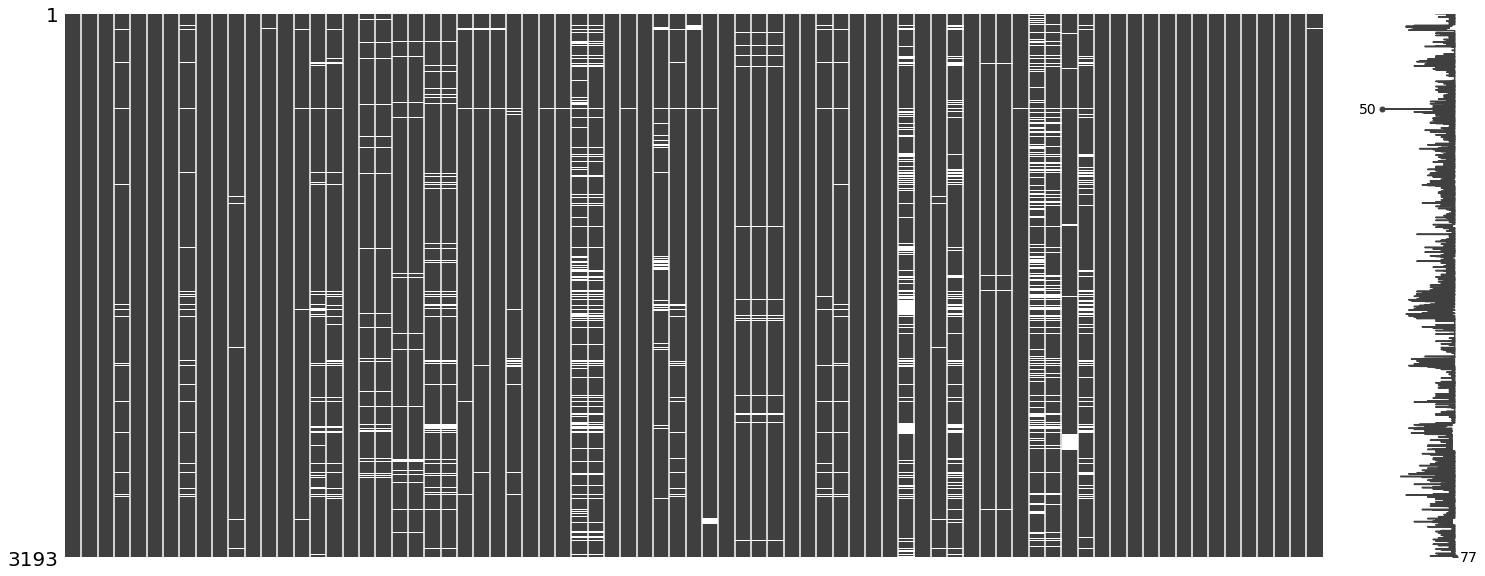

In [248]:
# Illustrate missing data
msno.matrix(features_df)

<AxesSubplot:>

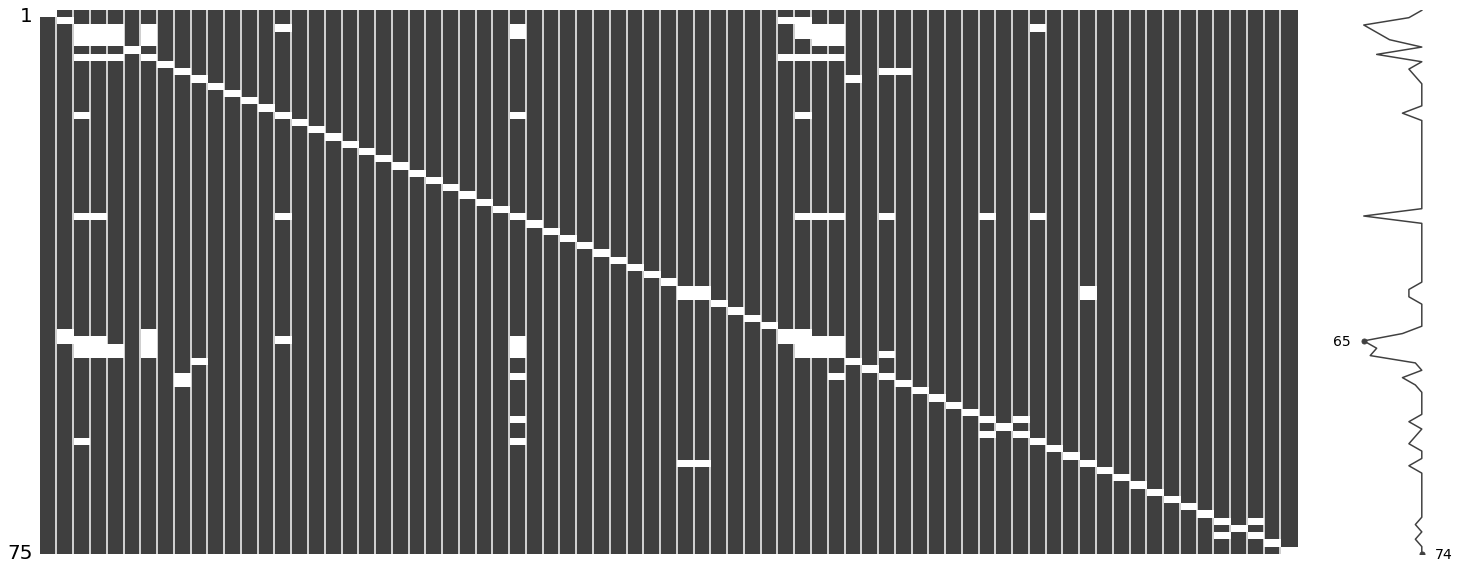

In [249]:
# Look for collinearity
corr = features_df.corr()
corr = corr[(corr < 0.7)&(corr > -0.7)]
msno.matrix(corr)

In [250]:
features_df.shape

(3193, 77)

In [251]:
# Find features of interest that are at least moderately correlated with dependent variable, and look at collinearity 
# between these variables
#df_for_corr = features_df.copy()
corr = features_df.corr()
for columns in corr.columns:
    if (corr.loc[column]['uninsured'] < 0.5) & (corr.loc[column]['uninsured'] > -0.5):
        df_for_corr.drop(columns=column)

collinear_corr = features_df.corr()

collinear_corr = collinear_corr[(collinear_corr<0.7)&(collinear_corr>-0.7)]


interaction_effects = defaultdict(list)
for index in collinear_corr.index:
    for column in collinear_corr.columns:
        #print(collinear_corr.loc[index][column])
        if math.isnan(collinear_corr.loc[index][column]):
            flattened_values = sum(list(interaction_effects.values()), [])
            if (index!=column)  and (index not in flattened_values):
                interaction_effects[index].append(column)
                

        
interaction_effects  

for values in interaction_effects.values():
    if values[0] in features_df.columns:
        features_df = features_df.drop(columns=values[0])

In [252]:
features = features_df.drop(['uninsured','state_fips_code','state_abbreviation', 'name'], axis = 1)
features_with_name = features_df.drop(['uninsured','state_fips_code','state_abbreviation'], axis = 1)
features_list = features_df.drop(['uninsured','state_fips_code', 'state_abbreviation'], axis = 1).columns.to_list()
imp = SimpleImputer()
features = imp.fit_transform(features)

labels = np.array(features_df['uninsured'])

features_df = pd.DataFrame(data=features_with_name, columns=features_list)


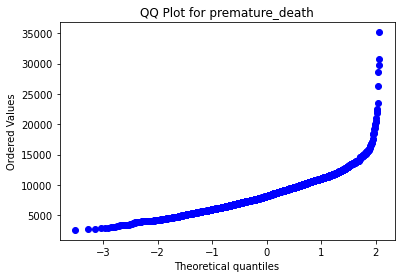

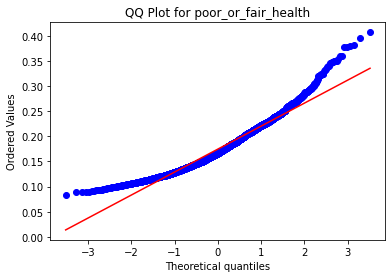

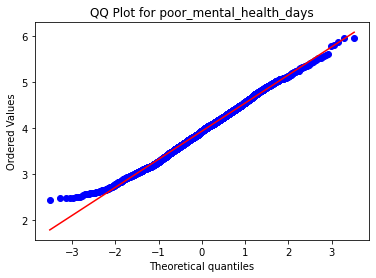

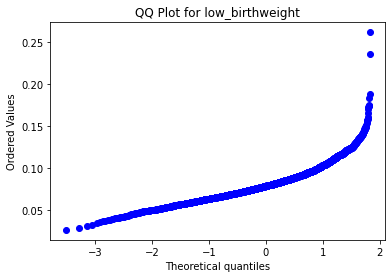

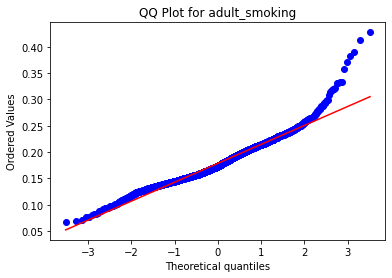

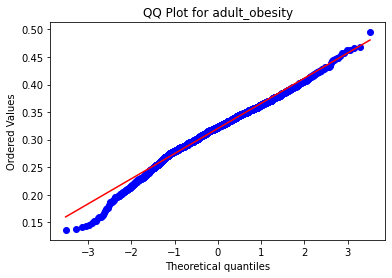

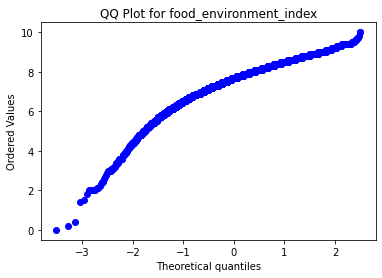

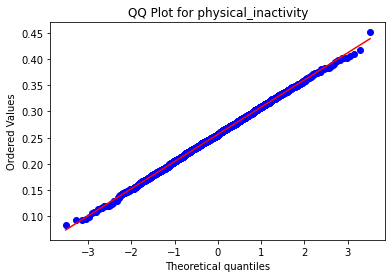

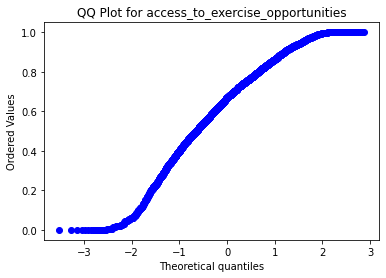

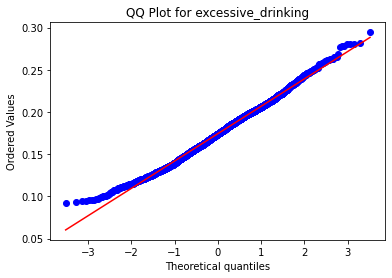

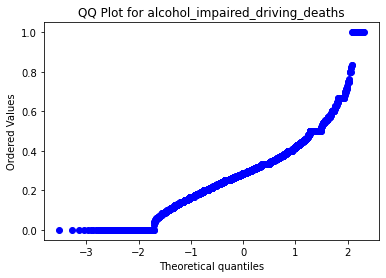

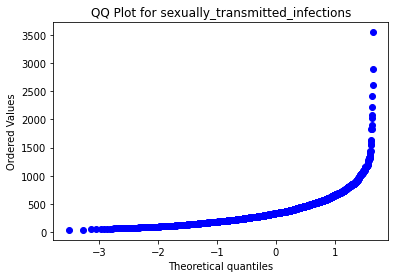

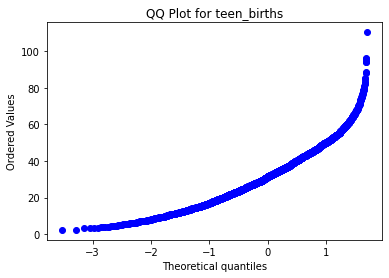

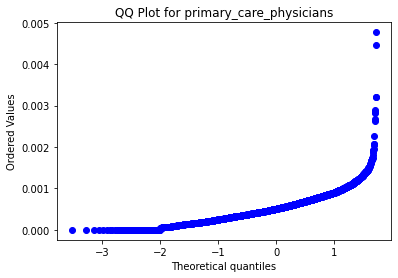

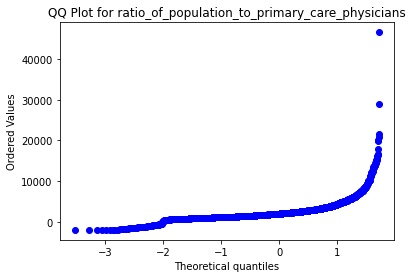

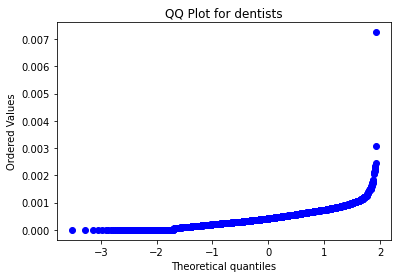

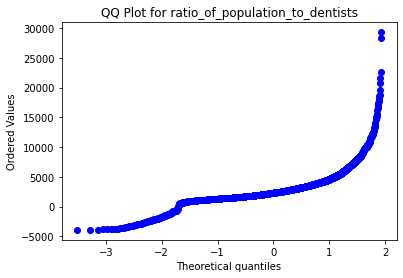

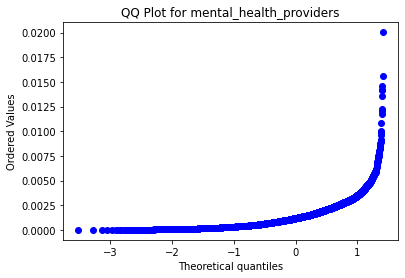

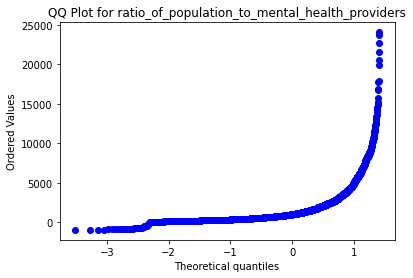

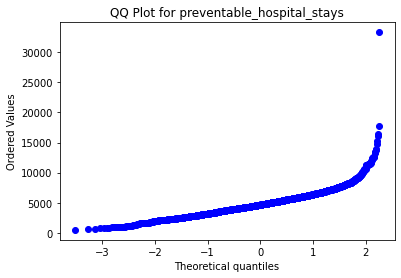

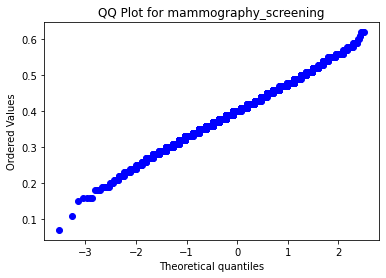

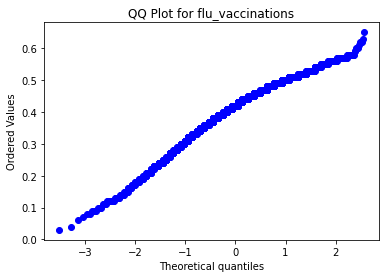

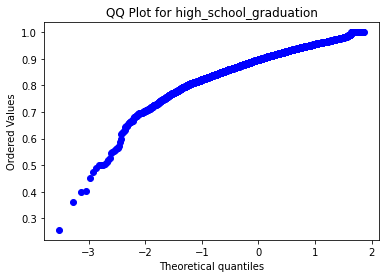

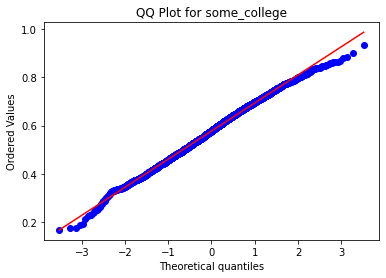

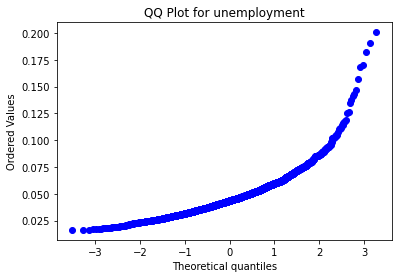

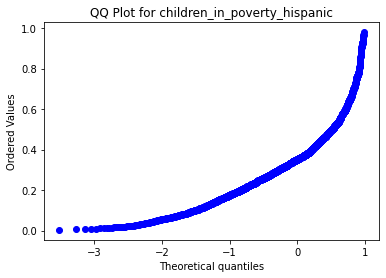

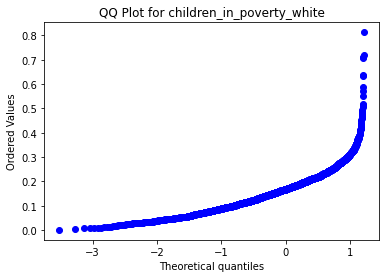

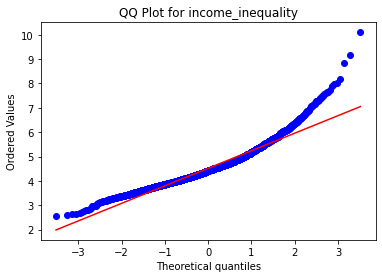

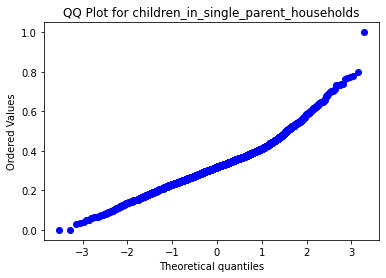

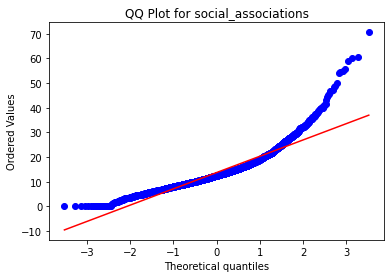

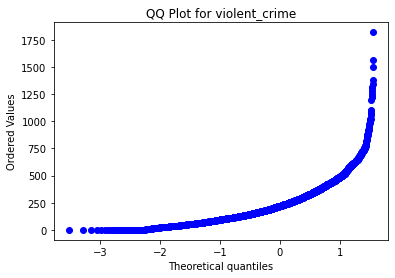

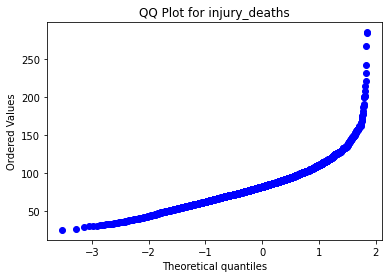

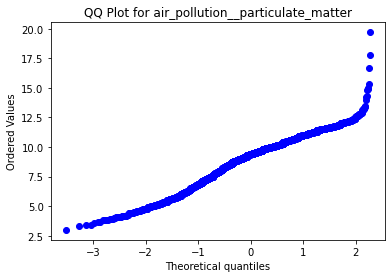

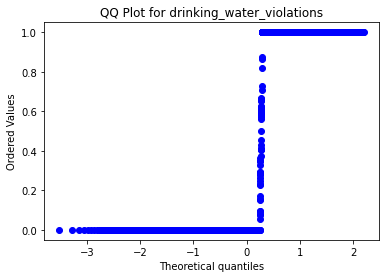

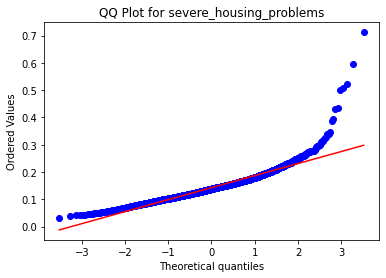

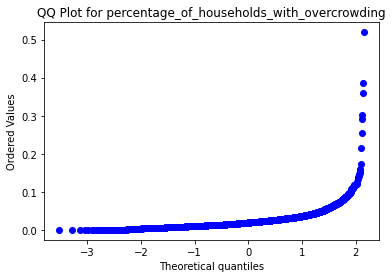

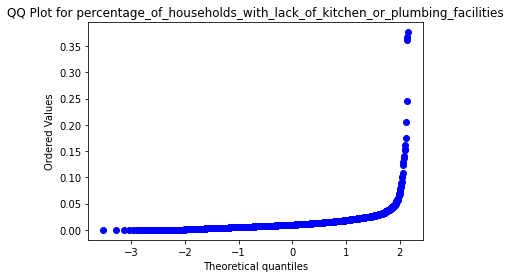

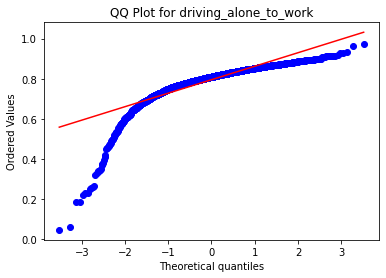

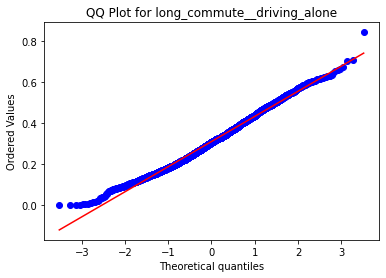

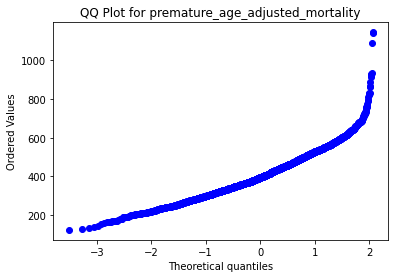

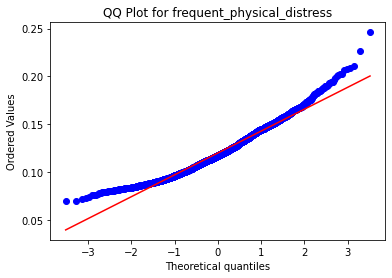

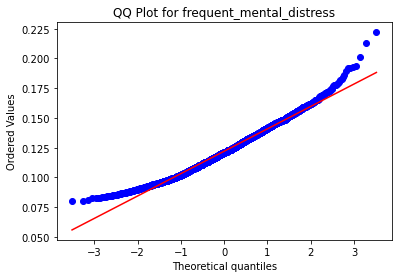

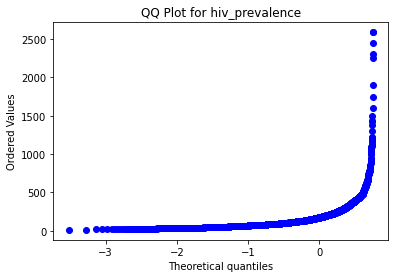

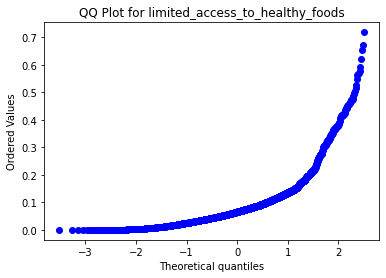

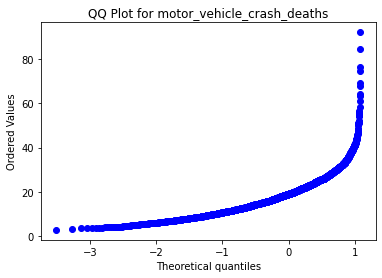

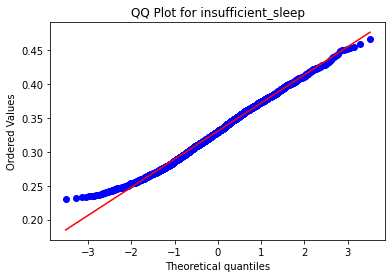

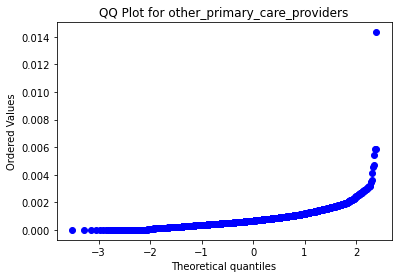

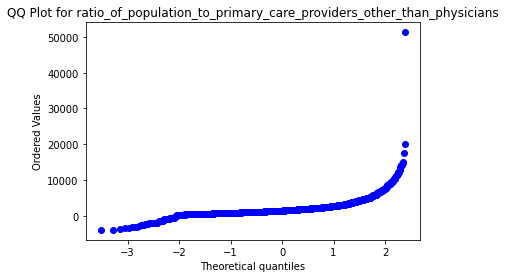

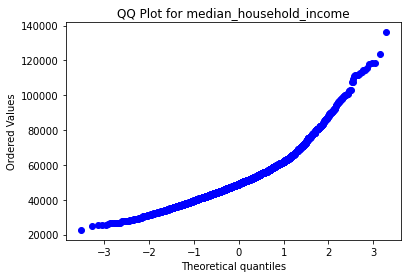

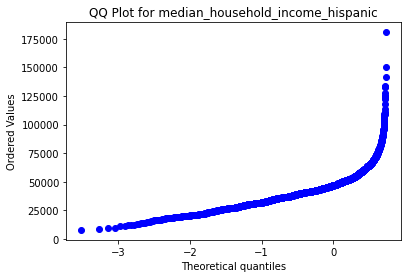

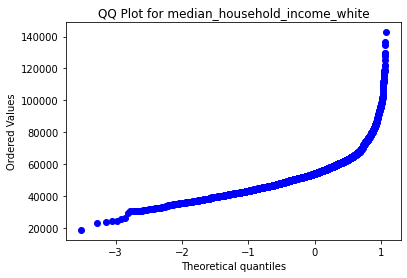

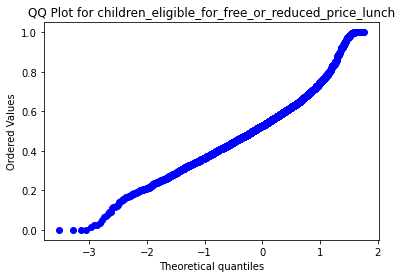

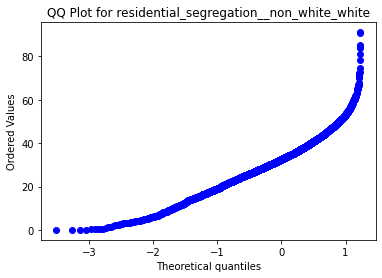

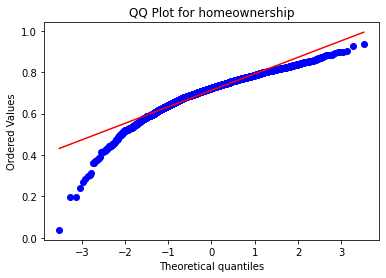

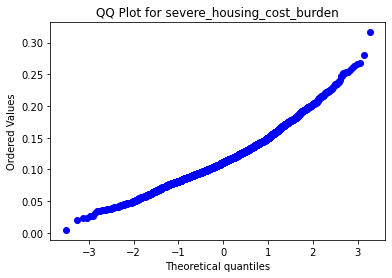

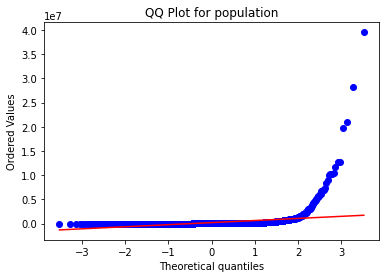

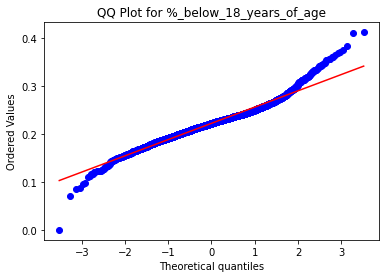

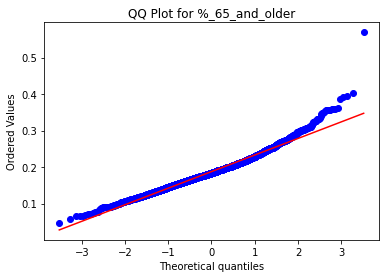

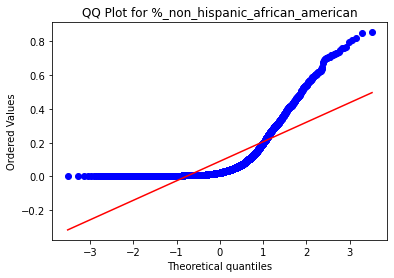

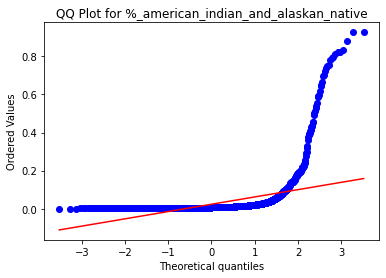

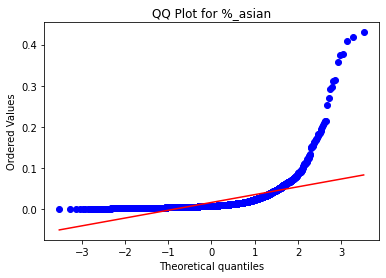

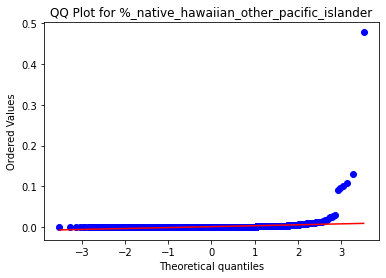

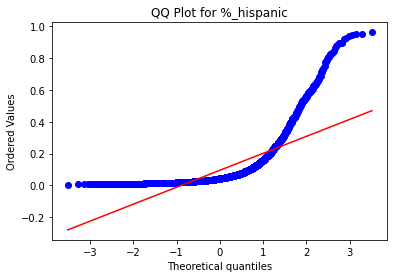

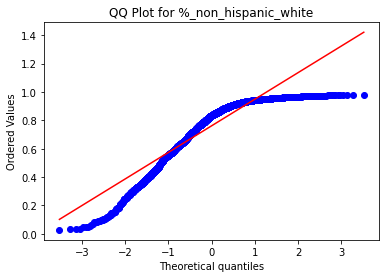

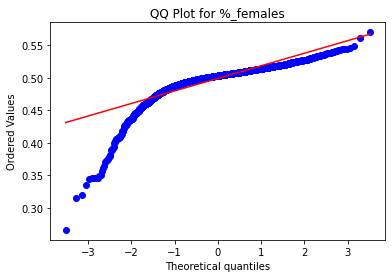

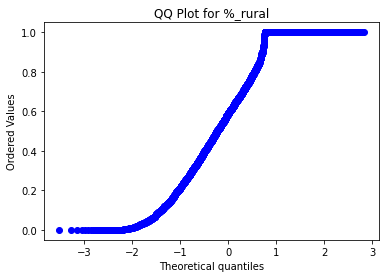

In [253]:
#features_df = features_df.copy().drop(columns=['state_fips_code', 'state_abbreviation', 'name'])

for column in features_df.columns:
    if column != 'name':
        stats.probplot((features_df[column]), dist="norm", plot=plt)
        plt.title("QQ Plot for {}".format(column))
        plt.show()
        plt.close()

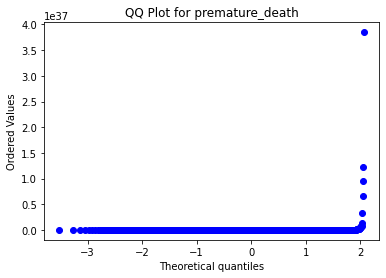

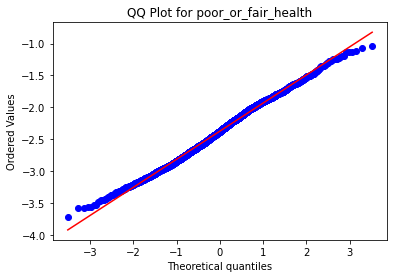

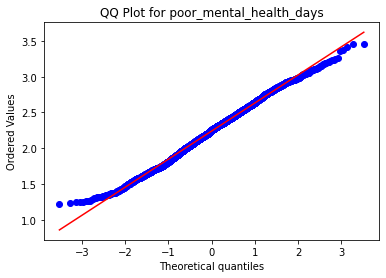

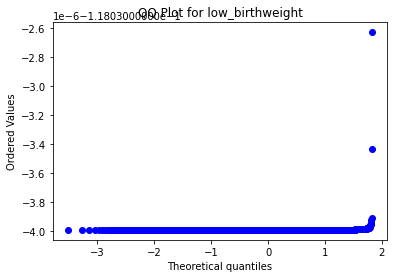

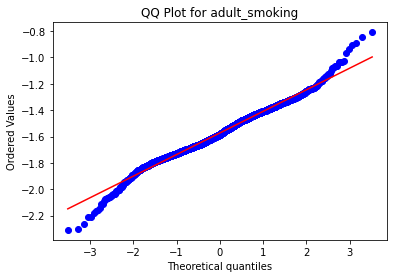

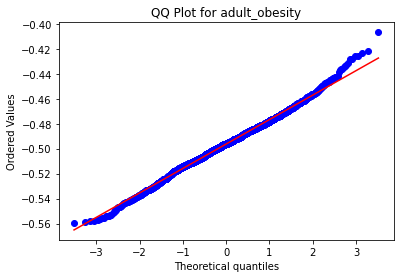

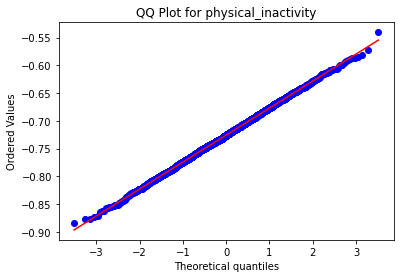

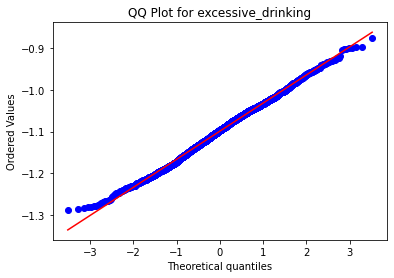

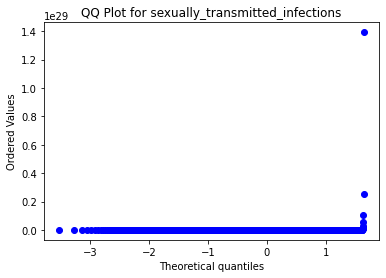

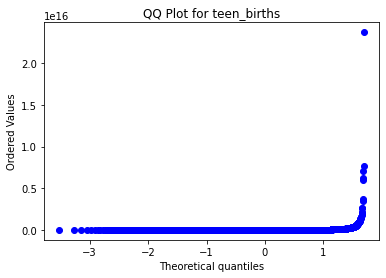

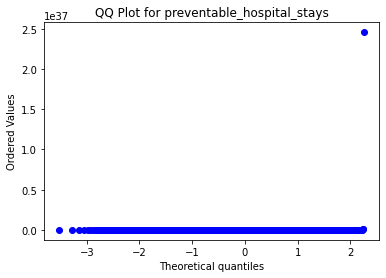

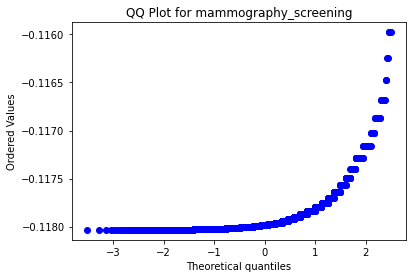

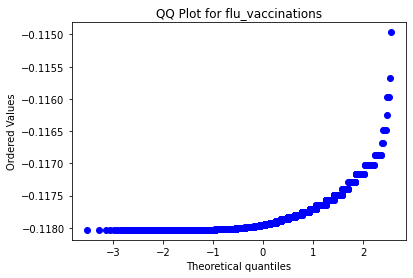

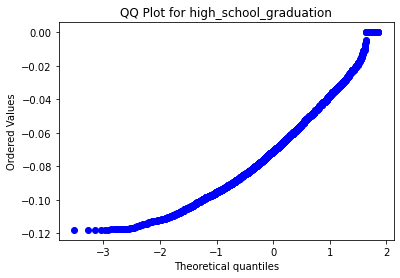

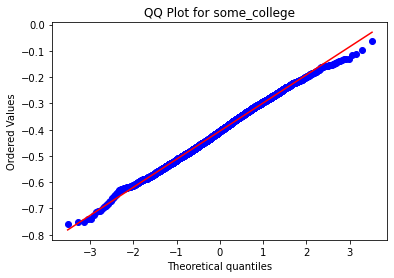

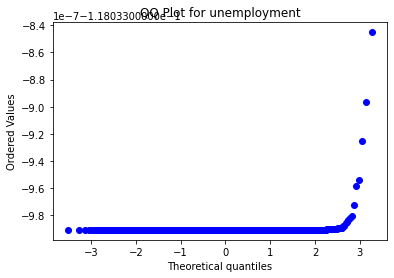

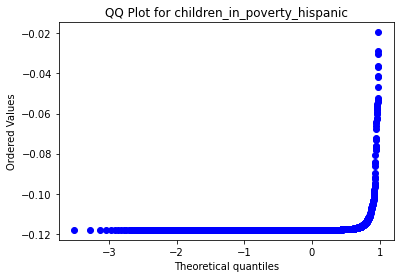

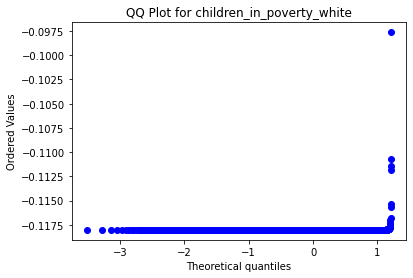

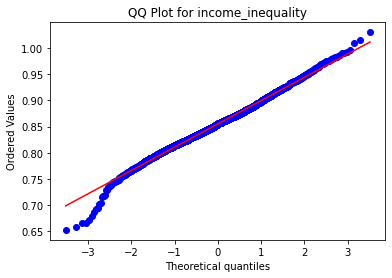

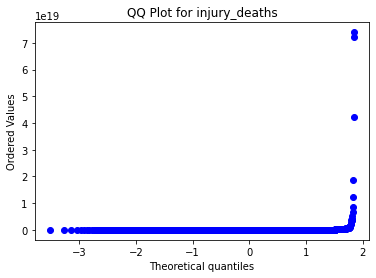

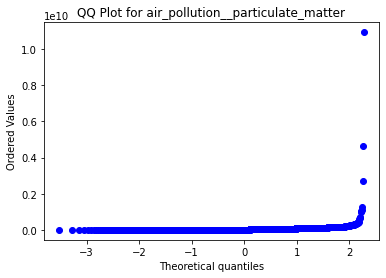

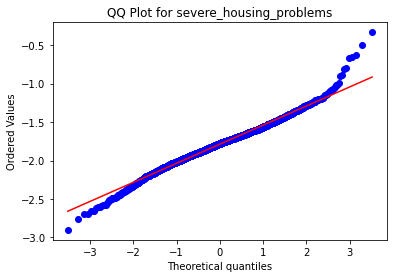

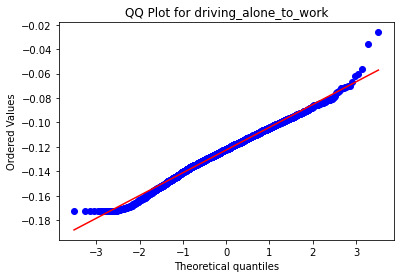

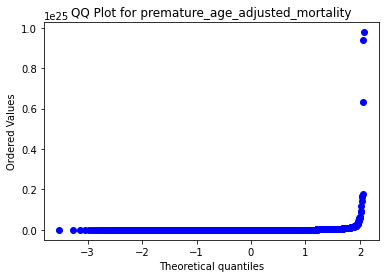

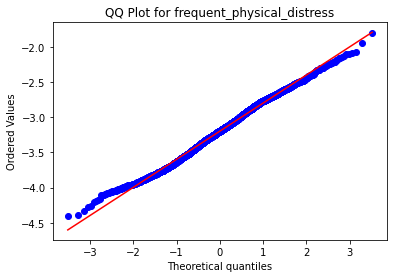

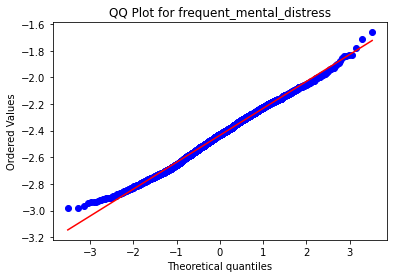

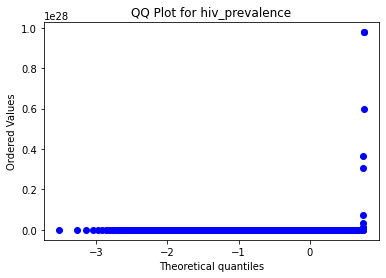

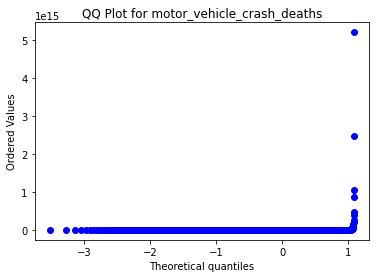

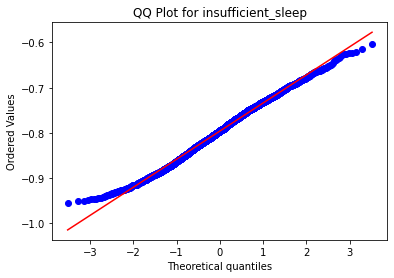

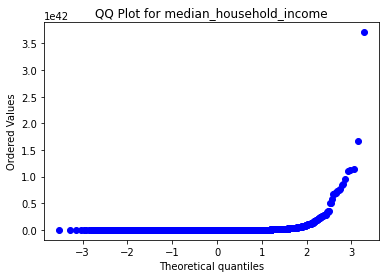

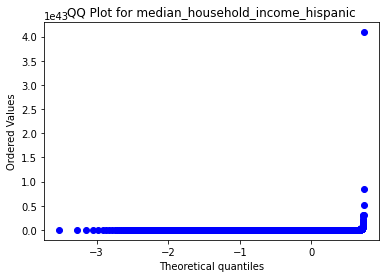

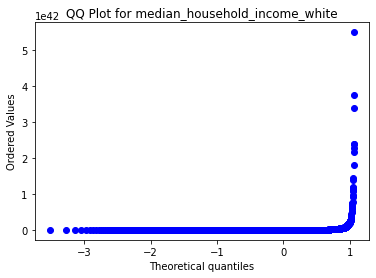

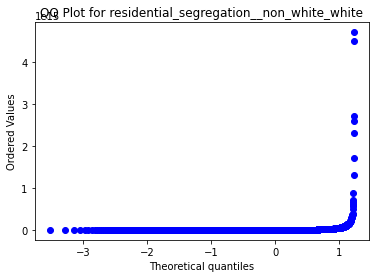

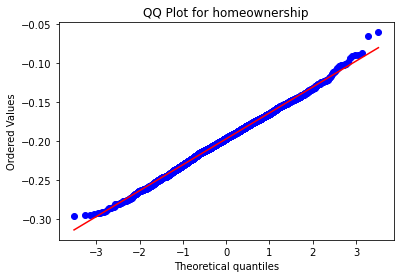

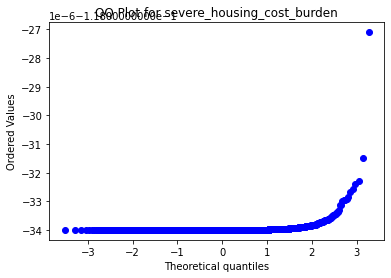

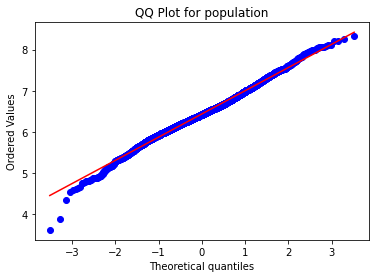

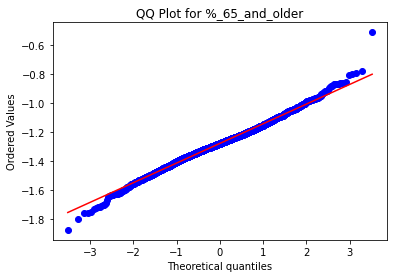

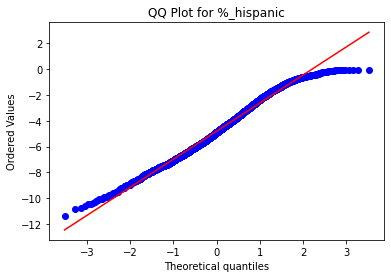

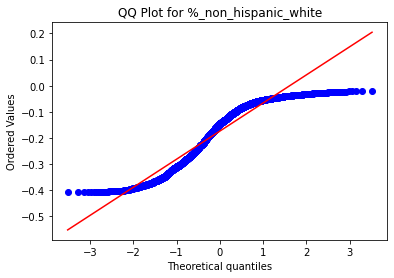

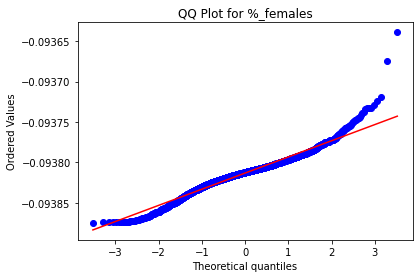

In [254]:
#features_df = features_df.copy().drop(columns=['state_fips_code', 'state_abbreviation', 'name'])

zero_or_negative_columns = [] # store features that couldn't be transformed


for column in features_df.columns:
    if column != 'name':
        #print(transformation_df[column].unique())
        if ~(features_df[column].values <= 0).any():
            transformed, lambda_val = stats.boxcox(features_df[column])
            features_df[column] = transformed
            #print("Column {0}, lambda value {1}".format(column, lambda_val))
        else:
            zero_or_negative_columns.append(column)

features_df = features_df.drop(columns=zero_or_negative_columns)

for column in features_df.columns:
    if column != 'name':
        stats.probplot((features_df[column]), dist="norm", plot=plt)
        plt.title("QQ Plot for {}".format(column))
        plt.show()
        plt.close()

In [255]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)

In [256]:
binom_glm = sm.GLM(train_labels, train_features, family=sm.families.Binomial())
binom_results = binom_glm.fit()

In [257]:
binom_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2554
Model:                            GLM   Df Residuals:                     2488
Model Family:                Binomial   Df Model:                           65
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -628.85
Date:                Fri, 23 Jul 2021   Deviance:                       21.454
Time:                        23:55:40   Pearson chi2:                     21.6
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.167e-05   9.94e-05     -0.117      0.906      -0.000       0.000
x2            -1.7782      7.222     -0.246      0.806     -15.932      12.376
x3            -0.3154      0.554     -0.570      0.569      -1.400       0.770
x4            -0.2704      5.606     -0.048      0.962     -11.258      10.718
x5             1.3380      5.126      0.261      0.794      -8.709      11.385
x6            -1.7811      2.413     -0.738      0.460      -6.510       2.948
x7            -0.1605      0.185     -0.869      0.385      -0.523       0.202
x8             2.3305      2.433      0.958      0.338      -2.439       7.100
x9             0.0040      0.397      0.010      0.992      -0.774       0.782
x10           -1.0981      3.731     -0.294      0.768      -8.410       6.214
x11           -0.0092      0.449     -0.021      0.984      -0.889       0.871
x12        -8.884e-06      0.000     -0.022      0.983      -0.001       0.001
x13            0.0034      0.009      0.380      0.704      -0.014       0.021
x14           38.9808    279.941      0.139      0.889    -509.693     587.655
x15         7.659e-07   3.13e-05      0.024      0.980   -6.06e-05    6.21e-05
x16         -164.8616    332.001     -0.497      0.619    -815.572     485.849
x17        -2.291e-06   2.99e-05     -0.077      0.939   -6.09e-05    5.64e-05
x18          -20.4005     54.813     -0.372      0.710    -127.833      87.032
x19         5.048e-06   3.04e-05      0.166      0.868   -5.45e-05    6.46e-05
x20        -6.495e-06   3.93e-05     -0.165      0.869   -8.35e-05    7.06e-05
x21           -0.2091      1.244     -0.168      0.867      -2.648       2.230
x22           -0.0118      0.903     -0.013      0.990      -1.781       1.758
x23            0.4814      1.040      0.463      0.644      -1.558       2.521
x24           -0.9973      1.001     -0.996      0.319      -2.960       0.965
x25           -6.0649      5.925     -1.024      0.306     -17.678       5.548
x26            0.0188      0.426      0.044      0.965      -0.816       0.853
x27           -0.2054      1.044     -0.197      0.844      -2.252       1.841
x28           -0.0229      0.122     -0.188      0.851      -0.262       0.216
x29           -0.6603      1.103     -0.599      0.549      -2.823       1.502
x30           -0.0022      0.012     -0.178      0.858      -0.027       0.022
x31         5.956e-05      0.000      0.130      0.897      -0.001       0.001
x32           -0.0017      0.005     -0.382      0.702      -0.011       0.007
x33           -0.0086      0.052     -0.165      0.869      -0.110       0.093
x34            0.0541      0.143      0.379      0.705      -0.226       0.334
x35            1.2671      4.466      0.284      0.777      -7.485      10.019
x36           -1.1089      5.708     -0.194      0.846     -12.296      10.079
x3

In [258]:
features = features_df[['name', 'teen_births', '%_non_hispanic_white']]
#features_with_name = features_df.drop(['uninsured','state_fips_code','state_abbreviation'], axis = 1)
features_list = features_df[['teen_births', '%_non_hispanic_white']].columns.to_list()
imp = SimpleImputer()
features = imp.fit_transform(features)

labels = np.array(features_df['uninsured'])

features_df = pd.DataFrame(data=features_with_name, columns=features_list)


ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Alabama'

In [37]:
"""
#updated_features_list = features_list.remove("name")
# Computing Variance Inflation Factors
sub_df = pd.DataFrame(data=features, columns=features_list)
vif_data_copy = sub_df.copy()


while not vif_data_copy.empty:
    print("entered")
    interesting_vars = sub_df.columns.to_list()
    X = sub_df[interesting_vars]

    # VIF dataframe
    print("entered again")
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    print(vif_data)

    if float('inf') in vif_data["VIF"].unique():
        feature_list = vif_data[vif_data['VIF']==float("inf")].feature.to_list()
        sub_df = sub_df.drop(columns=feature_list[0])
        vif_data_copy = vif_data[vif_data.feature!= feature_list[0]]
    elif ~ vif_data[vif_data['VIF'] >= 5].empty:
        feature_list = vif_data[vif_data['VIF']>= 5].feature.to_list()
        sub_df = sub_df.drop(columns=feature_list[0])
        vif_data_copy = vif_data[vif_data.feature!= feature_list[0]]
    else:
        vif_data_copy = pd.DataFrame()

sub_df
"""

entered
entered again


KeyboardInterrupt: 